In [0]:
import requests
import json
from collections import Counter
import random

#import matplotlib.pyplot as plt
#import seaborn as sns

#from sklearn import preprocessing
#from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
#from sklearn.decomposition import PCA
#from sklearn.pipeline import Pipeline

import pandas as pd # data preprocessing
import numpy as np # linear algebra

#import tensorflow as tf
#from tensorflow.keras import layers
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

# Part 1: Train a first Neural Network
El objetivo del siguiente notebook es entrenar una red neuronal simple para predecir dominios del dataset.

A continuación se muestra la arquitectura de la red a entrenar.


![Google's logo](https://www.google.com/images/logos/google_logo_41.png)

## Download the dataset
El siguiente código descarga el dataset ubicado en Google Drive y lo descomprime 

In [3]:
#dataset_url = 'https://drive.google.com/file/d/1XbasZMZzSmMUbji1Sslg4vT5MBiIhyFO/view?usp=sharing'

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


#download_file_from_google_drive('1BXQGSYbpdDaQdR_MeYfw1q4OjfmyXdmh', 'dataset.zip')                
#!unzip 'dataset.zip'

download_file_from_google_drive('1nzvm--XkmhjHgngNdjaemFIViXekaVWx', 'sm_dataset.zip')
!unzip 'sm_dataset.zip'

Archive:  sm_dataset.zip
  inflating: dataset.csv             
   creating: __MACOSX/
  inflating: __MACOSX/._dataset.csv  


## Load the dataset using pandas
The dataset is a csv file separated with tabs

In [0]:
df = pd.read_csv('dataset.csv', sep='\t')

## Explore the data

Let's do some checks to see if the data makes sense

In [5]:
df.head()

,domain_id,title
0,SANDALS_AND_FLIP_FLOPS,Sandalias Con Plataforma Mini Viamo Usadas Num 33/34 Niña
1,SPARK_PLUG_WIRESETS,Cable Para Bujia Prestolite (1127) Peugeot 405/1.8/1.9/2.0 1
2,MOTORCYCLE_HANDLEBAR_GRIPS,Protectores Mda Monster Zanella Zb D 110 4t 2005....
3,MOTORCYCLE_TIRES,Cubierta Moto 250 17 Hd01-1 Okinoi Okinoi - 110
4,AUTOMOTIVE_FILTER_KITS,Kit De Filtros Wega Toyota Hilux 2011


First, find how many classes we have in the dataset. This classes will be the output of the Neural Network

In [6]:
print("Número de classes:", len(df.domain_id.unique()))

Número de classes: 100


¿How many items do we have in the dataset?

In [7]:
print("Número de ejemplos:", len(df))

Número de ejemplos: 464092


Count how many items we have per class and:
 1. Make a line plot
 2. Plot a histogram distribution to see how balanced are the classes

(0, 5500)

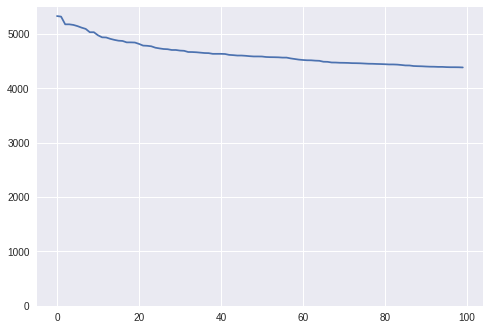

In [8]:
plt = (df.groupby('domain_id')
             .count()
             .sort_values('title', ascending=False)
             .reset_index()[['domain_id','title']]
             .rename(columns={"title":"counts"}))['counts'].plot.line()
plt.set_ylim(0,5500)

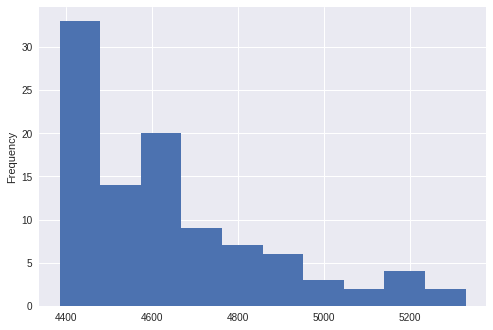

In [9]:
(df.groupby('domain_id')
             .count()
             .reset_index()[['domain_id','title']]
             .rename(columns={"title":"counts"}))['counts'].plot.hist()

## Prepare the data

In [0]:
max_items = 10000

### Tokenization and Vectorization

Create a vocabulary of words.

That is, given the text of the dataset, return a dict of word -> index 

["Kit De Filtros Wega Toyota Hilux 2011", "Protectores Mda Monster", ...]

{"kit":0, "de":1, ... ,"monster":121, ...}

View https://keras.io/preprocessing/text/

In [0]:
def vectorize_text(corpus):
  TOP_K = 20000

  MAX_SEQUENCE_LENGTH = 12

  tokenizer = text.Tokenizer(num_words=TOP_K, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')
  tokenizer.fit_on_texts(corpus)

  # Vectorize training and validation texts.
  text_sequences = tokenizer.texts_to_sequences(corpus)

  # Get max sequence length.
  max_length = len(max(text_sequences, key=len))
  if max_length > MAX_SEQUENCE_LENGTH:
      max_length = MAX_SEQUENCE_LENGTH

  # Fix sequence length to max value. Sequences shorter than the length are
  # padded in the beginning and sequences longer are truncated
  # at the beginning.
  text_sequences = sequence.pad_sequences(text_sequences, maxlen=max_length)
  return text_sequences, tokenizer
  

In [55]:
import time
tic = time.time()

text_sequences, tokenizer = vectorize_text(df['title'].values[:max_items])

toc = time.time()
    
print("Time to vectorize: " + str(1000*(toc-tic)) + " ms")


Time to vectorize: 454.54955101013184 ms


**word_counts**: ordereddict("word": "count")

**word_docs**: dic("word": "count docs it appears")

**word_index**: Vocabulary dict("word":index)

**document_count**:int #doc used to fit the Tokenizer.

In [0]:
#print(tokenizer.word_counts)
#print(tokenizer.word_counts)
#print(tokenizer.word_index)
#print(tokenizer.document_count)
#print(tokenizer.word_docs)

Now, it is time to vectorizer each individual example using the tokenizer fitted on the entire corpus

**binary**: Default, 1/0

**count**: BoW

**tfidf**: Term Frequency-Inverse Document Frequency

**freq**: Term Frequency as ratio within the document


In [0]:

encoded_docs = tokenizer.sequences_to_matrix(text_sequences[:max_items].tolist(), mode="count")


In [77]:
print(text_sequences.shape)
print(encoded_docs.shape)


(10000, 12)
(10000, 20000)


In [59]:
example_idx = 1000
print(df['title'].values[example_idx])
#print(text_sequences[1].tolist())
idx_tkn ={idx:tkn for tkn, idx in tokenizer.word_index.items()}
for tkn in text_sequences[example_idx].tolist():
  if tkn > 0:
    print(idx_tkn[tkn] ,encoded_docs[example_idx][tkn])


Maceta  Rotomoldeada  Con  Plantas De Interior Y Exterior
maceta 1.0
rotomoldeada 1.0
con 1.0
plantas 1.0
de 1.0
interior 1.0
y 1.0
exterior 1.0


### Vectorize the labels

Add a new column to the pandas dataframe with a integer representing the class label


In [0]:
df['label'] = df['domain_id'].factorize()[0]


Check that all the training examples belonging to the same domain have the same vectorizer label

In [61]:
df[df['label']==2].head()

,domain_id,title,label
2,MOTORCYCLE_HANDLEBAR_GRIPS,Protectores Mda Monster Zanella Zb D 110 4t 2005....,2
71,MOTORCYCLE_HANDLEBAR_GRIPS,Puños Mda Rubber Rojo Gilera Smash 110 Rd,2
152,MOTORCYCLE_HANDLEBAR_GRIPS,Puños Mda Street x Azul Kymco Activ 110 -,2
162,MOTORCYCLE_HANDLEBAR_GRIPS,Puños Mda Street x Negro Gilera Fu 110 -,2
258,MOTORCYCLE_HANDLEBAR_GRIPS,Puños Mda Ciclo Negro Pvc Gilera C - 110 2004 -,2


### Split the dataset in Train and Dev Sets

Split the dataset in two sets


1.   Train Set: We will first use 80% of the dataset to train the model.
2.   Dev Set: The other 20% will be used for cross validation and for tuning hyperparamenters 



## Build the model

We will first create a model using Keras Sequential API

Learn More: https://keras.io/getting-started/sequential-model-guide/

In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation


model = Sequential([
    Dense(1024, input_shape=(encoded_docs.shape[1],)),
    Activation('relu'),
    Dense(len(df[:max_items].domain_id.unique())),
    Activation('softmax'),
])

# For a multi-class classification problem
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Visualizing the Neural Network

In [49]:
# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1024)              20481024  
_________________________________________________________________
activation_10 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               102500    
_________________________________________________________________
activation_11 (Activation)   (None, 100)               0         
Total params: 20,583,524
Trainable params: 20,583,524
Non-trainable params: 0
_________________________________________________________________
None


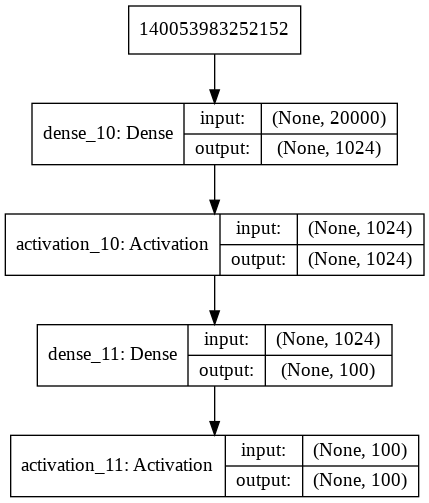

In [63]:
from keras.utils import plot_model
from IPython.display import Image

# Model summary
print(model.summary())

# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

## Train the model

In [0]:
from tensorflow.python.keras.utils import to_categorical

# Convert labels to categorical one-hot encoding
one_hot_labels = to_categorical(df['label'].values[:max_items])

In [65]:
print(df['label'].values[100])
one_hot_labels[100][df['label'].values[100]]

67


1.0

In [66]:
# Train the model, iterating on the data in batches of 32 samples
train_length = int(encoded_docs.shape[0] * 0.8)
val_length = encoded_docs.shape[0] - train_length

x_train = encoded_docs[:train_length]
y_train = one_hot_labels[:train_length]

x_val = encoded_docs[train_length:]
y_val = one_hot_labels[train_length:]

# Train and validate model.
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_val, y_val),
    verbose=1,  # Logs once per epoch.
    batch_size=256)


Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 2s 312us/sample - loss: 3.5392 - acc: 0.6021 - val_loss: 2.3637 - val_acc: 0.7950
Epoch 2/10
8000/8000 [==============================] - 2s 279us/sample - loss: 1.3475 - acc: 0.9236 - val_loss: 1.1419 - val_acc: 0.8660
Epoch 3/10
8000/8000 [==============================] - 2s 277us/sample - loss: 0.4879 - acc: 0.9672 - val_loss: 0.7361 - val_acc: 0.8765
Epoch 4/10
8000/8000 [==============================] - 2s 278us/sample - loss: 0.2113 - acc: 0.9820 - val_loss: 0.5646 - val_acc: 0.8890
Epoch 5/10
8000/8000 [==============================] - 2s 278us/sample - loss: 0.1027 - acc: 0.9894 - val_loss: 0.4994 - val_acc: 0.8995
Epoch 6/10
8000/8000 [==============================] - 2s 278us/sample - loss: 0.0546 - acc: 0.9937 - val_loss: 0.4527 - val_acc: 0.9015
Epoch 7/10
8000/8000 [==============================] - 2s 276us/sample - loss: 0.0311 - acc: 0.9966 - val_loss: 0.4255 - va

### Visualizing learning curve

In [0]:
import matplotlib.pyplot as plt

def visualize_training_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

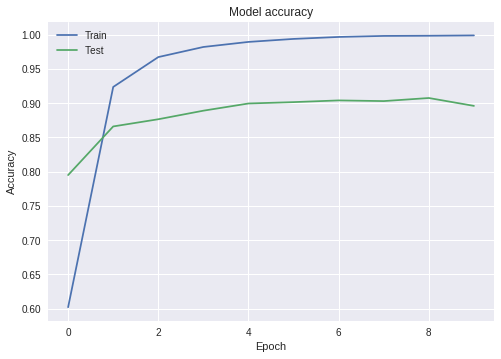

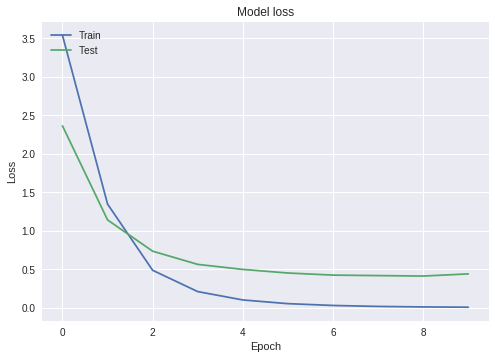

In [68]:
visualize_training_history(history)

### Visualize the Confussion Matrix

## Test the model on some examples

# Part 2: Recurrent Neural Network

In [84]:
x_train = text_sequences[:train_length]
y_train = one_hot_labels[:train_length]

x_val = text_sequences[train_length:]
y_val = one_hot_labels[train_length:]

print(text_sequences.shape)
print(encoded_docs.shape)

(10000, 12)
(10000, 20000)


## RNN same approach

In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout, LSTM, Embedding, Masking

num_features = encoded_docs.shape[1]
title_max_length = text_sequences.shape[1]

model = Sequential([
    LSTM(units=512, input_shape=title_max_length),
    Dropout(0.5),
    Dense(len(df[:max_items].domain_id.unique()), activation='softmax')
])

# For a multi-class classification problem
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train and validate model.
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    validation_data=(x_val, y_val),
    verbose=1,  # Logs once per epoch.
    batch_size=256)

## RNN using embedding Layer

In [89]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout, LSTM, Embedding, Masking

num_features = encoded_docs.shape[1]
title_max_length = text_sequences.shape[1]

model = Sequential([
    Embedding(input_dim=num_features,
              output_dim=200,
              input_length=title_max_length),
    LSTM(units=512),
    Dropout(0.5),
    Dense(len(df[:max_items].domain_id.unique()), activation='softmax')
])

# For a multi-class classification problem
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train and validate model.
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    validation_data=(x_val, y_val),
    verbose=1,  # Logs once per epoch.
    batch_size=256)

Train on 8000 samples, validate on 2000 samples
Epoch 1/20
8000/8000 [==============================] - 3s 397us/sample - loss: 4.5419 - acc: 0.0246 - val_loss: 4.3366 - val_acc: 0.0440
Epoch 2/20
8000/8000 [==============================] - 2s 278us/sample - loss: 4.1203 - acc: 0.0430 - val_loss: 3.8393 - val_acc: 0.0840
Epoch 3/20
8000/8000 [==============================] - 2s 279us/sample - loss: 3.2682 - acc: 0.1651 - val_loss: 2.6014 - val_acc: 0.3560
Epoch 4/20
8000/8000 [==============================] - 2s 280us/sample - loss: 1.7108 - acc: 0.5468 - val_loss: 1.6036 - val_acc: 0.6050
Epoch 5/20
8000/8000 [==============================] - 2s 283us/sample - loss: 0.6916 - acc: 0.8292 - val_loss: 0.9662 - val_acc: 0.7940
Epoch 6/20
8000/8000 [==============================] - 2s 276us/sample - loss: 0.2985 - acc: 0.9370 - val_loss: 0.9450 - val_acc: 0.8045
Epoch 7/20
8000/8000 [==============================] - 2s 279us/sample - loss: 0.1762 - acc: 0.9644 - val_loss: 0.8572 - va

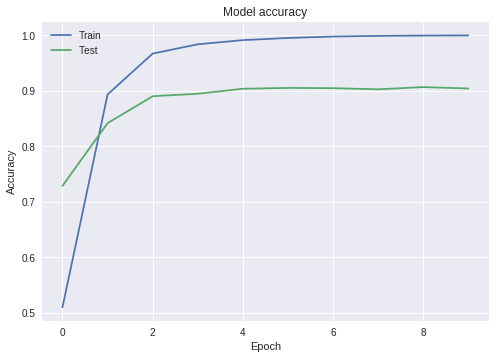

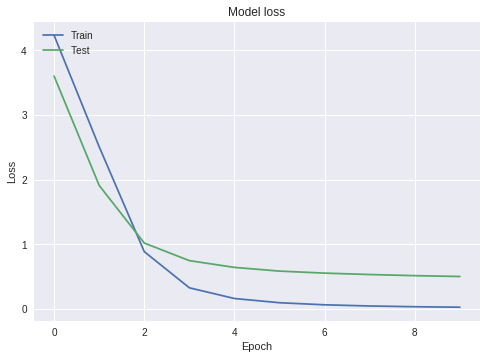

In [74]:
visualize_training_history(history)